In [1]:
## Libraries that we will use ##
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.utils import shuffle
import keras


# Garbage Collector to free up memory
import gc
gc.enable()                     # Activate 

In [2]:
## Incorportate databases into the project ##
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")
order_products_prior = pd.read_csv("order_products__prior.csv")
order_products_train = pd.read_csv("order_products__train.csv")
orders = pd.read_csv("orders.csv")
order_products__test = orders[(orders["eval_set"] == "test")]
products = pd.read_csv("products.csv")
sample_submission = pd.read_csv("sample_submission.csv")

In [3]:
## No has convertido los objetos a category, por si da algun error ##
aisles['aisle'] = aisles['aisle'].astype('category')
departments['department'] = departments['department'].astype('category')
orders['eval_set'] = orders['eval_set'].astype('category')
products['product_name'] = products['product_name'].astype('category')


In [4]:
# We combine orders with order_products_prior only for those tuples that have the same order_id
op = orders.merge(order_products_prior, on='order_id', how='inner')

# Obtaining new fields #

In [5]:
# Campos acerca del comportamiento del usuario #
## Número de pedidos que realiza cada uno de los clientes ##
client = op.groupby('user_id')['order_number'].max().to_frame('c_total_orders')
client = client.reset_index()
## Frecuencia con que un cliente vuelve a pedir un producto ##
c_reorder = op.groupby('user_id')['reordered'].mean().to_frame('c_reordered_ratio')
c_reorder = c_reorder.reset_index()
# Combinamos ambas tablas #
client = client.merge(c_reorder, on='user_id', how='left')
# Eliminamos variables que ya no son útiles # 
del c_reorder
gc.collect()

24

In [6]:
## Campos acerca de las características del producto ##
# Número de compras de cada uno de los productos
product = op.groupby('product_id')['order_id'].count().to_frame('p_total_purchases')
product = product.reset_index()
# Probabilidad de que se vuelva a comprar un producto #
# Filtramos a un mínimo de 40 veces 
p_reorder = op.groupby('product_id').filter(lambda x: x.shape[0] >40)
p_reorder = p_reorder.groupby('product_id')['reordered'].mean().to_frame('p_reorder_ratio')
p_reorder = p_reorder.reset_index()

# Combinamos ambas tablas #
product = product.merge(p_reorder, on='product_id', how='left')

# Reparamos los datos #
product['p_reorder_ratio'] = product['p_reorder_ratio'].fillna(value=0)

# Eliminamos variables que ya no son útiles # 
del p_reorder
gc.collect()

0

In [7]:
# Veces en que un usuario compró un producto #
client_product = op.groupby(['user_id', 'product_id'])['order_id'].count().to_frame('uxp_total_bought')
client_product = client_product.reset_index()

In [8]:
# Frecuencia un cliente compra un producto después se su primera compra 
times_bought = op.groupby(['user_id', 'product_id'])[['order_id']].count()
times_bought.columns = ['Times_Bought_N']
N_orders = op.groupby('user_id')['order_number'].max().to_frame('N_orders')
first_order = op.groupby(['user_id', 'product_id'])['order_number'].min().to_frame('first_order')
first_order  = first_order.reset_index()

# Combinamos las tablas temporales
client_orders = pd.merge(N_orders, first_order, on='user_id', how='right')

# El +1 permite contar desde la primera compra
client_orders['Order_Range_D'] = client_orders.N_orders - client_orders.first_order + 1

client_product_ratio = pd.merge(times_bought, client_orders, on=['user_id', 'product_id'], how='left')

client_product_ratio['client_product_reorder_ratio'] = client_product_ratio.Times_Bought_N / client_product_ratio.Order_Range_D

#Remove temporary
client_product_ratio = client_product_ratio.drop(['Times_Bought_N', 'N_orders', 'first_order', 'Order_Range_D'], axis=1)
#Remove temporary DataFrames
del [times_bought, first_order, client_orders]

client_product = client_product.merge(client_product_ratio, on=['user_id', 'product_id'], how='left')
del client_product_ratio

In [9]:
# Cuántas veces un cliente compró un producto concreto en sus últimos 5 pedidos #
op['order_number_back'] = op.groupby('user_id')['order_number'].transform(max) - op.order_number +1 
op5 = op[op.order_number_back <= 5]

last_five = op5.groupby(['user_id','product_id'])[['order_id']].count()
last_five.columns = ['times_last5']

client_product = client_product.merge(last_five, on=['user_id', 'product_id'], how='left')
del last_five
client_product = client_product.fillna(0)

In [10]:
# Combinamos las diferentes tablas
data = client_product.merge(client, on='user_id', how='left')
data = data.merge(product, on='product_id', how='left')

In [11]:
# Eliminamos todas las variables temporales
del op, client, product, client_product
gc.collect()

122

In [12]:
# Nos quedamos con aquellos pedidos etiquetados como train y test
orders_future = orders[(orders.eval_set=='train')]
orders_future = orders_future[ ['user_id', 'eval_set', 'order_id'] ]
# Combinamos las tablas
data = data.merge(orders_future, on='user_id', how='left')
# Separamos los datos del train
data_train = data[data.eval_set=='train']
# Combinamos las tablas
data_train = data_train.merge(order_products_train[['product_id','order_id', 'reordered']], on=['product_id','order_id'], how='left' )
# Reparamos datos
data_train['reordered'] = data_train['reordered'].fillna(0)
data_train = data_train.set_index(['user_id', 'product_id'])
# Eliminamos aquellos datos no útiles
data_train = data_train.drop(['eval_set', 'order_id'], axis=1)

In [13]:
array_train= data_train.to_numpy()

array_train_x = array_train[:,:-1]

array_train_y = array_train[:,-1]
def train_test_split(a, b):
    a, b = shuffle(a, b)

    len_newtrain = int(0.6*a.shape[0])
    len_newval = a.shape[0]- len_newtrain
    

    train_x = a[:len_newtrain]
    a = np.delete(a, range(len_newtrain), axis=0)
    val_x = a[:len_newval]
    train_y = b[:len_newtrain]
    b = np.delete(b, range(len_newtrain), axis=0)
    val_y = b[:len_newval]

    return train_x, val_x, train_y, val_y
t_x, v_x, t_y, v_y = train_test_split(array_train_x, array_train_y)

In [14]:
model1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(7,)),
    keras.layers.Dense(16, activation=tf.nn.softmax),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(2, activation=tf.nn.softmax),

])
model1.summary()

N_epochs = 4

opt1 = tf.keras.optimizers.SGD(learning_rate=0.00001)
model1.compile(optimizer = opt1 , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

history1 = model1.fit(t_x, t_y, epochs = N_epochs, validation_data = (v_x, v_y))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 16)                128       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 34        
Total params: 162
Trainable params: 162
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
158900/158900 [==============================] - 128s 801us/step - loss: 0.5639 - accuracy: 0.9010 - val_loss: 0.5118 - val_accuracy: 0.9014
Epoch 2/4
158900/158900 [==============================] - 127s 802us/step - loss: 0.5122 - accuracy: 0.9

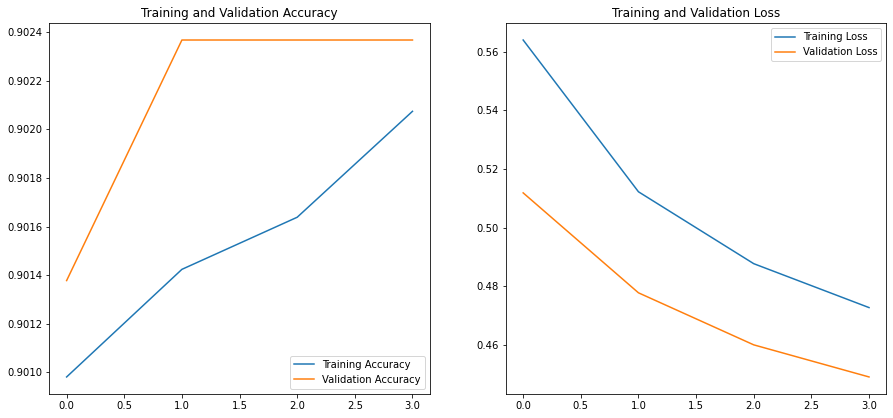

In [15]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(N_epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# model1.save("model1-A")

In [16]:
model2 = keras.Sequential([
    keras.layers.Flatten(input_shape=(7,)),
    keras.layers.Dense(8, activation=tf.nn.softmax),
    keras.layers.Dense(16, activation=tf.nn.softmax),
    keras.layers.Dense(32, activation=tf.nn.softmax),
    keras.layers.Dense(64, activation=tf.nn.softmax),
    keras.layers.Dense(32, activation=tf.nn.softmax),
    keras.layers.Dense(16, activation=tf.nn.softmax),
    keras.layers.Dense(8, activation=tf.nn.softmax),
    keras.layers.Dense(4, activation=tf.nn.softmax),
    keras.layers.Dense(2, activation=tf.nn.softmax),

])
model2.summary()
N_epochs = 4

opt2 = tf.keras.optimizers.Adam(learning_rate=0.00001)
model2.compile(optimizer = opt2 , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

history2 = model1.fit(t_x, t_y, epochs = N_epochs, validation_data = (v_x, v_y))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 7)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 64        
_________________________________________________________________
dense_3 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 16)               

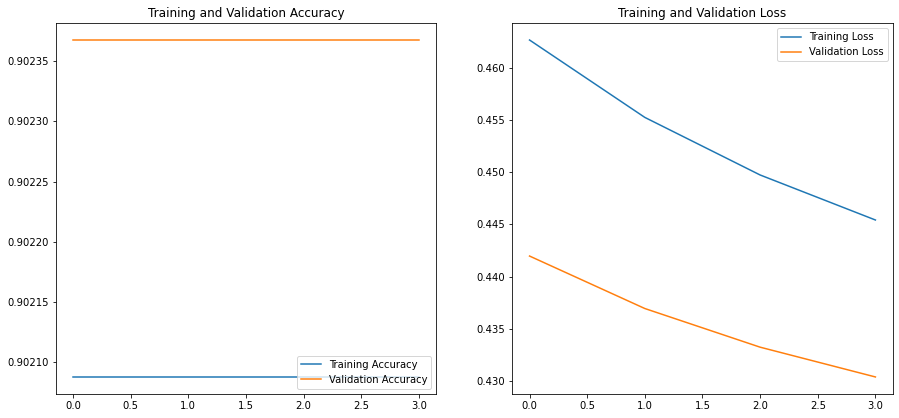

In [17]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(N_epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
model3 = keras.Sequential([
    keras.layers.Flatten(input_shape=(7,)),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.softmax),

])
model3.summary()
N_epochs = 4

opt3 = tf.keras.optimizers.Adamax(learning_rate=0.0001)
model3.compile(optimizer = opt3 , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

history3 = model3.fit(t_x, t_y, epochs = N_epochs, validation_data = (v_x, v_y))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 7)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                128       
_________________________________________________________________
dense_12 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 34        
Total params: 434
Trainable params: 434
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
158900/158900 [==============================] - 134s 839us/step - loss: 0.4110 - accuracy: 0.9017 - val_loss: 0.4105 - val_accuracy: 0.9024
Epoch 2/4
158900/158900 [==============================] - 128s 806us/step - loss: 0.4106 - accuracy: 0

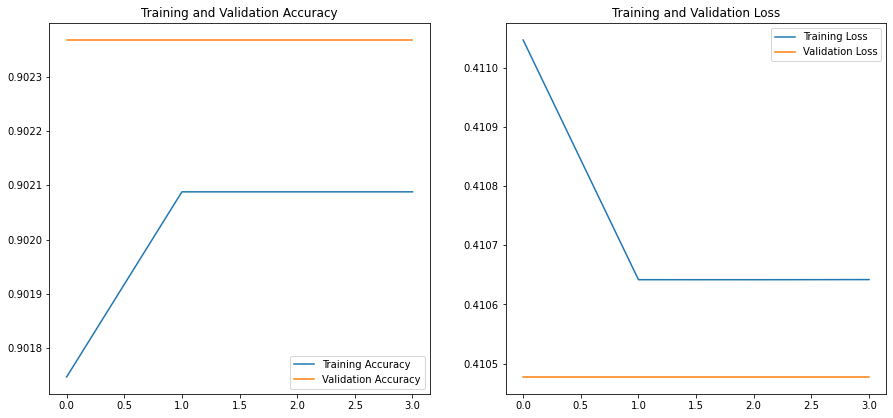

In [19]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(N_epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
X_train, y_train = data_train.drop('reordered', axis=1), data_train.reordered
feature_importances_df = pd.DataFrame(model.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances_df)

##################################
# FEATURE IMPORTANCE - GRAPHICAL
##################################
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values()
feat_importances.plot(kind='barh')

############################
# DELETE TEMPORARY OBJECTS #
############################
gc.collect()

NameError: name 'model' is not defined

In [ ]:
# TRAIN FULL 

###########################
## IMPORT REQUIRED PACKAGES
###########################
from sklearn.ensemble import RandomForestClassifier

########################################
## SPLIT DF TO: X_train, y_train (axis=1)
########################################
X_train, y_train = data_train.drop('reordered', axis=1), data_train.reordered

############################
## INSTANTIATE AND TRAIN MODEL
############################
rfc = RandomForestClassifier(n_estimators=10, n_jobs=-1 ,random_state=42)
model = rfc.fit(X_train, y_train)

############################
# FEATURE IMPORTANCE - AS DF
############################
feature_importances_df = pd.DataFrame(model.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances_df)

##################################
# FEATURE IMPORTANCE - GRAPHICAL
##################################
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values()
feat_importances.plot(kind='barh')

############################
# DELETE TEMPORARY OBJECTS #
############################
gc.collect()
